In [36]:
#Importing the libraries. 
import pandas as pd
import pickle
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
from sklearn.linear_model import Lasso



In [2]:
#Let's import the dataset.

dataset = pd.read_csv("/content/ipl.csv")

In [3]:
dataset.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [4]:
dataset.shape

(76014, 15)

In [5]:
dataset.describe()

,mid,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
count,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000
mean,308.627740,74.889349,2.415844,9.783068,33.216434,1.120307,24.962283,8.869287,160.901452
std,178.156878,48.823327,2.015207,5.772587,14.914174,1.053343,20.079752,10.795742,29.246231
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000
25%,154.000000,34.000000,1.000000,4.600000,24.000000,0.000000,10.000000,1.000000,142.000000
50%,308.000000,70.000000,2.000000,9.600000,34.000000,1.000000,20.000000,5.000000,162.000000
75%,463.000000,111.000000,4.000000,14.600000,43.000000,2.000000,35.000000,13.000000,181.000000
max,617.000000,263.000000,10.000000,19.600000,113.000000,7.000000,175.000000,109.000000,263.000000


In [6]:
#Let's start cleaning the data

#First we will drop the colums which we are not going to consider for our model prediction.
dataset.drop(labels=["mid", "venue","batsman","bowler", "striker", "non-striker"], axis=1, inplace=True)

In [7]:
dataset.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [8]:
#Listing all the teams present in the dataset
dataset["bat_team"].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Deccan Chargers', 'Kings XI Punjab',
       'Royal Challengers Bangalore', 'Delhi Daredevils',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant'], dtype=object)

In [9]:
#During the league some of the teams get relegated each year so we will only create prediciton for the popular teams. 

popular_teams = ['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Kings XI Punjab',
       'Royal Challengers Bangalore', 'Delhi Daredevils', 'Pune Warriors', 'Sunrisers Hyderabad']

In [10]:
#Now we will filter out the dataset based on the consistent teams only.

dataset = dataset[dataset["bat_team"].isin(popular_teams) & dataset["bowl_team"].isin(popular_teams) ]

In [11]:
#Checking if the teams were dropped or not.
dataset["bat_team"].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
       'Delhi Daredevils', 'Pune Warriors', 'Sunrisers Hyderabad'],
      dtype=object)

In [12]:
#removing the first 5 overs since we atleast need to have 5 overs data to make a prediction.
dataset = dataset[dataset['overs']>=5.0]

In [13]:
#Now if we check our dataset we will find that the dataset also includes dates, so we will consider that in the date time format.
# https://stackoverflow.com/questions/57094792/how-to-strip-date-time-in-python
dataset['date'] = dataset['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
dataset.head

<bound method NDFrame.head of             date               bat_team  ... wickets_last_5  total
32    2008-04-18  Kolkata Knight Riders  ...              0    222
33    2008-04-18  Kolkata Knight Riders  ...              1    222
34    2008-04-18  Kolkata Knight Riders  ...              1    222
35    2008-04-18  Kolkata Knight Riders  ...              1    222
36    2008-04-18  Kolkata Knight Riders  ...              1    222
...          ...                    ...  ...            ...    ...
75884 2017-05-19  Kolkata Knight Riders  ...              4    107
75885 2017-05-19  Kolkata Knight Riders  ...              4    107
75886 2017-05-19  Kolkata Knight Riders  ...              4    107
75887 2017-05-19  Kolkata Knight Riders  ...              4    107
75888 2017-05-19  Kolkata Knight Riders  ...              5    107

[43792 rows x 9 columns]>

In [15]:
#Now data preprocessing on textual data
#Converted Categorical data to numerical
ndataset = pd.get_dummies(data=dataset, columns=["bat_team", "bowl_team"])
ndataset.head()

,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,bat_team_Mumbai Indians,bat_team_Pune Warriors,bat_team_Rajasthan Royals,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Pune Warriors,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
32,2008-04-18,61,0,5.1,59,0,222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
33,2008-04-18,61,1,5.2,59,1,222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
34,2008-04-18,61,1,5.3,59,1,222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
35,2008-04-18,61,1,5.4,59,1,222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
36,2008-04-18,61,1,5.5,58,1,222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [17]:
# Rearranging the columns
ndataset = ndataset[['date', 'bat_team_Chennai Super Kings', 'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
              'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians', 'bat_team_Rajasthan Royals',
              'bat_team_Royal Challengers Bangalore', 'bat_team_Sunrisers Hyderabad',
              'bowl_team_Chennai Super Kings', 'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
              'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians', 'bowl_team_Rajasthan Royals',
              'bowl_team_Royal Challengers Bangalore', 'bowl_team_Sunrisers Hyderabad',
              'overs', 'runs', 'wickets', 'runs_last_5', 'wickets_last_5', 'total']]

In [21]:
# Splitting the data into train and test set where all the years before 2017 will be training set
X_train = ndataset.drop(labels='total', axis=1)[ndataset['date'].dt.year <= 2016]
X_test = ndataset.drop(labels='total', axis=1)[ndataset['date'].dt.year >= 2017]

In [23]:
#Spliting the data into train and test
y_train = ndataset[ndataset['date'].dt.year <= 2016]['total'].values
y_test = ndataset[ndataset['date'].dt.year >= 2017]['total'].values

In [24]:
# Removing the 'date' column
X_train.drop(labels='date', axis=True, inplace=True)
X_test.drop(labels='date', axis=True, inplace=True)

In [29]:
#Implementing Ridge Regression
ridge=Ridge()
parameters={'alpha':[1e-20,1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,50,60,70,80,90,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-20, 1e-15, 1e-10, 1e-08, 0.001, 0.01, 1,
                                   5, 10, 20, 30, 35, 40, 50, 60, 70, 80, 90,
                                   100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [30]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 100}
-321.7336525644981


In [40]:
prediction1=ridge_regressor.predict(X_test)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


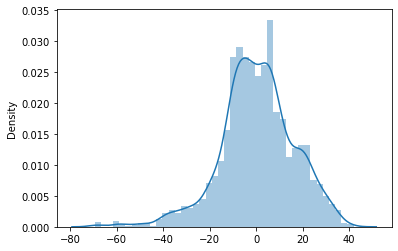

In [41]:
#Let's check for the prediction
import seaborn as sns
sns.distplot(y_test-prediction1)

In [44]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction1))
print('MSE:', metrics.mean_squared_error(y_test, prediction1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction1)))

MAE: 12.189068125905967
MSE: 253.63302942412435
RMSE: 15.92586039823671


In [37]:
#Applying Lasso regression model
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(X_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4845515.678003629, tolerance: 2808.323826229016
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4846931.130618623, tolerance: 2869.2796198774845
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5113407.2254876625, tolerance: 2971.1514774862085
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4776442.5

{'alpha': 1}
-319.8909855618398


In [42]:
prediction2=lasso_regressor.predict(X_test)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


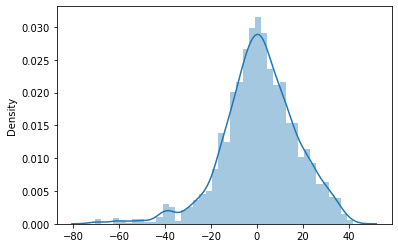

In [43]:
sns.distplot(y_test-prediction2)

In [45]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction2))
print('MSE:', metrics.mean_squared_error(y_test, prediction2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction2)))

MAE: 12.265349865133853
MSE: 263.56386400096784
RMSE: 16.234650104051145
